In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import csv

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
fold = 'fold_2'

### Preprocessing

In [ ]:
# cria um dicionario com a chave sendo cada k_fold e os values são outro dicionario com cada key sendo o tipo de objeto (treinamento ou validacao) e os valores são um dataframe
k_folds = { fold : {"x_train": pd.read_csv(f'./K Folds Cross Validation/{fold}/x_train_{fold}').drop("Unnamed: 0", axis = 1),
                    "x_val": pd.read_csv(f'./K Folds Cross Validation/{fold}/x_val_{fold}').drop("Unnamed: 0", axis = 1),
                    "y_train": pd.read_csv(f'./K Folds Cross Validation/{fold}/y_train_{fold}').drop("Unnamed: 0", axis = 1)['weather'],  #abre o dataframe e ja faz o mapeamento
                    "y_val": pd.read_csv(f'./K Folds Cross Validation/{fold}/y_val_{fold}').drop("Unnamed: 0", axis = 1)['weather'],}     #abre o dataframe e ja faz o mapeamento
                     
                     for fold in os.listdir("./K Folds Cross Validation/")}
    
k_folds

In [4]:
x_train = k_folds.get(fold).get('x_train')
y_train = k_folds.get(fold).get('y_train')

x_test = k_folds.get(fold).get('x_val')
y_test = k_folds.get(fold).get('y_val')

In [ ]:
dataset = pd.concat([x_train, y_train], axis = 1)
dataset_test = pd.concat([x_test, y_test], axis = 1)
dataset

In [6]:
weather_rkm = pd.read_csv('weather_reverse_key_mapping.csv', index_col= 'code')#.drop(['0'], axis = 1)
season_rkm = pd.read_csv('season_reverse_key_mapping.csv', index_col= 'code')#.drop(['0.0'], axis = 1)

In [7]:
weather_reverse_key_mapping = {code : weather_rkm.loc[code].item() for code in weather_rkm.index}
season_reverse_key_mapping = {code : season_rkm.loc[code].item() for code in season_rkm.index}


In [8]:
dataset['weather'] = dataset['weather'].map(weather_reverse_key_mapping)
dataset['season'] = dataset['season'].map(season_reverse_key_mapping)

dataset_test['weather'] = dataset_test['weather'].map(weather_reverse_key_mapping)
dataset_test['season'] = dataset_test['season'].map(season_reverse_key_mapping)

In [9]:
dataset

,season,humidity,pressure,temperature,wind,weather
0,spring,58,1012,15,7,few_clouds
1,spring,57,1012,15,7,few_clouds
2,spring,57,1012,15,7,few_clouds
3,spring,57,1012,15,7,few_clouds
4,spring,57,1012,15,6,few_clouds
...,...,...,...,...,...,...
34859,spring,36,1019,16,3,sky_is_clear
34860,spring,38,1019,16,1,sky_is_clear
34861,spring,54,1019,14,2,sky_is_clear
34862,spring,62,1020,12,3,sky_is_clear


In [ ]:
dataset_test

### Probability

In [11]:
p_of_ = {}
p_of_['weather'] = {weather : 0 for weather in sorted(pd.unique(dataset["weather"]))}

In [ ]:
# P(X = weather)

count = 0
for weather in p_of_['weather'].keys():
    for index in range(len(dataset['weather'])):
        if dataset.loc[index, 'weather'] == weather:
            count+=1
    p_of_['weather'][weather] = count/len(dataset['weather'])

    count = 0
    
p_of_['weather']

In [13]:
sum = 0
for value in p_of_['weather'].values():
    sum+= value
sum

0.9999999999999998

In [ ]:
#cria a pmf de cada variavel climatica (termo normalizador (denominador da fração) da equação do Teorema de Bayes )

#desabilitado por causa da simplificação da equação
# for variavel_climatica in ['season', 'humidity', 'pressure', 'temperature', 'wind']:
#     p_of_[variavel_climatica] = {i : dataset[variavel_climatica].value_counts(normalize = True)[i] for i in dataset[variavel_climatica].value_counts(normalize = True).index}

# p_of_.keys()

In [ ]:
# verifica a probabilidade total de cada variavel climatica 

# for variavel_climatica in ['season', 'humidity', 'pressure', 'temperature', 'wind']:
#     sum = 0
#     for value in p_of_[variavel_climatica].values():
#         sum+= value
#     print(sum)

In [ ]:
dataset['weather'].value_counts(normalize = True)

In [ ]:
p_of_['weather']

In [18]:
# calcula a probabilidade condicional de cada variavel climatica dado o clima (P = var_clim | Clima)
conditional_probability = {}

for weather in pd.unique(dataset['weather']):
    count = 0
    for variavel_climatica in ['season', 'humidity', 'pressure', 'temperature', 'wind']:
        temporary_dataset = dataset[dataset['weather'].str.contains(f'{weather}|{variavel_climatica}')][[variavel_climatica,'weather']]  # cria um sliced dataset temporario 
        for index in temporary_dataset.index:  
            if temporary_dataset.loc[index, 'weather'] != weather:  # valida que df['weather'][i] é estritamente igual à weather do loop
                temporary_dataset.drop( index = index, inplace = True)

        # calcula a probabilidade condicional
        conditional_probability[f"{variavel_climatica}_given_{weather}"] = {i[0] : temporary_dataset.value_counts(normalize = True)[i] for i in temporary_dataset.value_counts(normalize = True).index  }

In [ ]:
conditional_probability

In [ ]:
# verifica a probabilidade total de cada probabilidade condicional (∑ p(xi|y) = 1) / xi em variavel climatica

for variavel_climatica in ['season','humidity', 'pressure', 'temperature', 'wind']:
    for weather in pd.unique(dataset['weather']):
        probability = 0
        for prob in conditional_probability[f'{variavel_climatica}_given_{weather}'].values():
            probability += prob
        print(probability)

### Training

In [21]:
# Naive Bayes 

# p(clima | x1, x2, x3) = p(clima , | x1  ). p(x1) . p(clima)

# P(X = Clima | Y = Var_clim (Xn)) == (P(Var_clim (Xn) | Clima). P(Clima)) / P(Var_clima (Xn)), onde X = [x1,x2,...xn]
# Assumindo a independencia entre eventos de X e Y, então:  P(Var_clima(xi) | Clima, Var_clima(xj) == P(Var_clima(xi) | Clima) ; i,j ∈ ℕ  e  i ≠ j

# Simplificando por  P(Var_clima (Xn)), então Naive Bayers será:  ŷ  =  P(Clima | Var_clim (Xn))  =  P(Var_clim (Xn) | Clima). P(Clima)



In [22]:
def NaiveBayes(weather: str, season_value: str, humidity_value: int, pressure_value: int, temperature_value: int, wind_value: int) -> float:
    
    def season_given_weather(season_value, weather):
       if not season_value in conditional_probability[f'season_given_{weather}'].keys():
           #season_value = find_closest(list(conditional_probability[f'season_given_{weather}'].keys()), season_value)
           return 0
       else:
        return conditional_probability[f'season_given_{weather}'][season_value]
    
    def humidity_given_weather(humidity_value, weather):
       if not humidity_value in conditional_probability[f'humidity_given_{weather}'].keys():
           #humidity_value = find_closest(list(conditional_probability[f'humidity_given_{weather}'].keys()), humidity_value)
           return 0
       else:
        return conditional_probability[f'humidity_given_{weather}'][humidity_value]
    
    def pressure_given_weather(pressure_value, weather):
        if not pressure_value in conditional_probability[f'pressure_given_{weather}'].keys():
           return 0 #pressure_value = find_closest(list(conditional_probability[f'pressure_given_{weather}'].keys()), pressure_value)
        else:
            return  conditional_probability[f'pressure_given_{weather}'][pressure_value]
    
    def temperature_given_weather(temperature_value, weather):
        if not temperature_value in conditional_probability[f'temperature_given_{weather}'].keys():
           return 0 #temperature_value = find_closest(list(conditional_probability[f'temperature_given_{weather}'].keys()), temperature_value)
        else:
            return  conditional_probability[f'temperature_given_{weather}'][temperature_value]
    
    def wind_given_weather(wind_value, weather):
        if not wind_value in conditional_probability[f'wind_given_{weather}'].keys():
           return 0 #wind_value = find_closest(list(conditional_probability[f'wind_given_{weather}'].keys()), wind_value)
        else:
         return  conditional_probability[f'wind_given_{weather}'][wind_value]
    
    def p_of_weather(weather):
        if not weather in p_of_['weather'].keys():
            raise NotImplementedError
        return p_of_['weather'][weather]  
    

    def find_closest(list_of_values : list, k): #Ignore (disabled)
        list_of_values.sort()
        closest_num = list_of_values[0]

        for num in list_of_values:
            if abs(num - k) < abs(closest_num - k):
                closest_num = num
            if num > k:
                break
        return closest_num
    
    return p_of_weather(weather) * humidity_given_weather(humidity_value, weather) * season_given_weather(season_value, weather) * pressure_given_weather(pressure_value, weather) * temperature_given_weather(temperature_value, weather) * wind_given_weather(wind_value, weather)

### Evaluation

In [23]:
# Avaliação do modelo

y_true = []
y_predicted = []

#faz a previsão do modelo para encontrar a classe (weather) com maior probabilidade (a classe com maior probabilidade será a previsão do modelo para os atributos de entrada Xi)
for index in dataset_test.index: #testa cada amostra contida no dataset de teste
    current_prediction = {}
    for weather in pd.unique(dataset_test['weather']):
        current_prediction[weather] =  round(
                                            NaiveBayes(
                                                        weather = weather,  
                                                        season_value = dataset_test.loc[index, 'season'], 
                                                        humidity_value = dataset_test.loc[index, 'humidity'], 
                                                        pressure_value = dataset_test.loc[index, 'pressure'], 
                                                        temperature_value =  dataset_test.loc[index, 'temperature'], 
                                                        wind_value = dataset_test.loc[index, 'wind']
                                                        ),
                                            10)
                             

    #salva os valores da predicao atual (para que as probabilidades sejam organizadas em ordem crescente para a comparação)
    values_mapping = {probability : weather for weather, probability in current_prediction.items()} 


    #verifica a maior probabilidade calculada pelo modelo e a sua classe
    NB_choice = [0,0,0,0,]
    classe1 = 0
    classe2 = 0
    classe3 = 0
    classe4 = 0
    
    for probability in sorted(current_prediction.values()):
        if probability > NB_choice[0]:
            classe1, classe2, classe3, classe4 = values_mapping.get(probability), classe1, classe2, classe3
            NB_choice[0], NB_choice[1], NB_choice[2], NB_choice[3] = probability, NB_choice[0], NB_choice[1],  NB_choice[2]

    y_true.append(dataset_test.loc[index, 'weather'])
    y_predicted.append(classe1)
    
#calcula a matriz de confusão
matrix = confusion_matrix(y_true, y_predicted, labels = pd.unique(dataset_test['weather']))

Text(0.5, 1.0, 'Confusion Matrix')

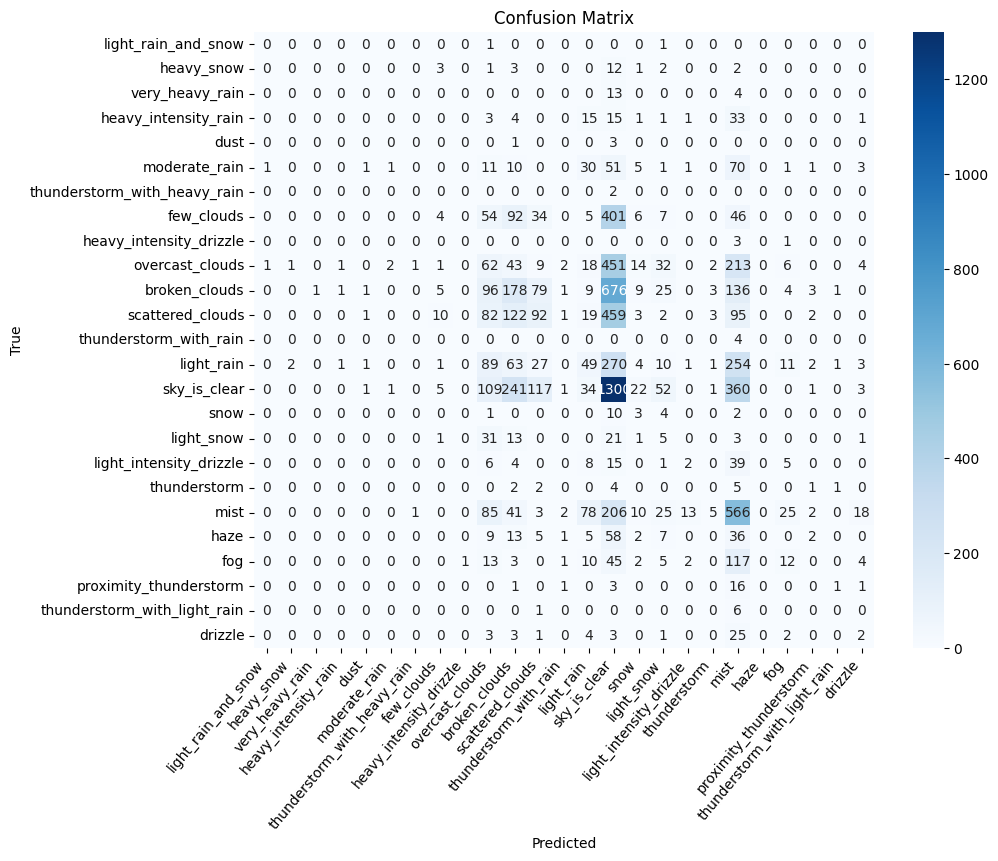

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pd.unique(dataset_test['weather']), yticklabels=pd.unique(dataset_test['weather']))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=50, ha = 'right')
plt.title('Confusion Matrix')

In [ ]:
report_dict = classification_report(y_true, y_predicted, labels = pd.unique(dataset_test['weather']), output_dict= True)
print(report_dict)

# Saval os arquivos
csv_filename = f'metrics_{fold}.csv'

with open(csv_filename, 'w', newline='') as metrics_file:
    metrics_writer = csv.writer(metrics_file)
    
    metrics_writer.writerow(['class', 'precision', 'recall', 'f1-score', 'support'])

    for class_label, metrics in report_dict.items():
        metrics_writer.writerow([class_label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])

In [28]:
'''dada a complexidade do dataset, e também pela redundancia nas classes, seja pela:

     i. repetição na ocorrencia dos nomes (proximity_thunderstorm, thunderstorm, thunderstorm_with_light_rain )  
    ii. eventos similares, que necessitam de um especialista para diferenciar-los (fog, haze, mist)
   iii. ambos (scattered clouds e broken clouds; few clouds e sky is clear) 

    considera-se um acerto caso o ground truth esteja entre as 4 maiores probabilidades'''

count = 0

for index in dataset_test.index: #testa cada amostra contida no dataset de teste
    current_prediction = {}
    for weather in pd.unique(dataset_test['weather']):
        current_prediction[weather] =  round(
                                            NaiveBayes(
                                                        weather = weather,  
                                                        season_value = dataset_test.loc[index, 'season'], 
                                                        humidity_value = dataset_test.loc[index, 'humidity'], 
                                                        pressure_value = dataset_test.loc[index, 'pressure'], 
                                                        temperature_value =  dataset_test.loc[index, 'temperature'], 
                                                        wind_value = dataset_test.loc[index, 'wind']
                                                        ),
                                            10)
                             

    #verifica a maior probabilidade calculada pelo modelo e a sua classe
    NB_choice = [0,0,0,0,]
    classe1 = 0
    classe2 = 0
    classe3 = 0
    classe4 = 0

    #contagem de acertos do modelo 
    values_mapping = {probability : weather for weather, probability in current_prediction.items()} # salva os valores a predicao atual (para que as probabilidades sejam organizadas em ordem crescente para a comparação)

    for probability in sorted(current_prediction.values()):
        if probability > NB_choice[0]:
            classe1, classe2, classe3, classe4 = values_mapping.get(probability), classe1, classe2, classe3
            NB_choice[0], NB_choice[1], NB_choice[2], NB_choice[3] = probability, NB_choice[0], NB_choice[1],  NB_choice[2]
    
    

    if classe1 == dataset_test.loc[index, 'weather'] or classe2 == dataset_test.loc[index, 'weather'] or classe3 == dataset_test.loc[index, 'weather'] or classe4 == dataset_test.loc[index, 'weather']:
        count+=1
        #print(count,index)

accuracy = count/index
print(f'Considerando as 4 classes como um acerto, a Acurácia é {round(accuracy, 2)}%\n Acertos: {count}\n Total: {index}')

Considerando as 4 classes como um acerto, a Acurácia é 0.67%
 Acertos: 5878
 Total: 8715
